In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import SimpleITK as sitk
import time
import os
import CTProjector.functions_collection as ff
import nibabel as nb
import CTProjector.transformation as transform

import ct_projector.projector.cupy as ct_projector
import ct_projector.projector.cupy.fan_equiangular as ct_fan
import ct_projector.projector.numpy as numpy_projector
import ct_projector.projector.numpy.fan_equiangluar as numpy_fan

In [12]:
# load image
filename = '/workspace/Documents/data/CT_motion/CT_images/example_CT_volume/patient_3/original/3.nii.gz'
ct = nb.load(filename)
spacing = ct.header.get_zooms()
img = ct.get_fdata()

[1.       0.683594 0.683594]
(1, 418, 630, 630)


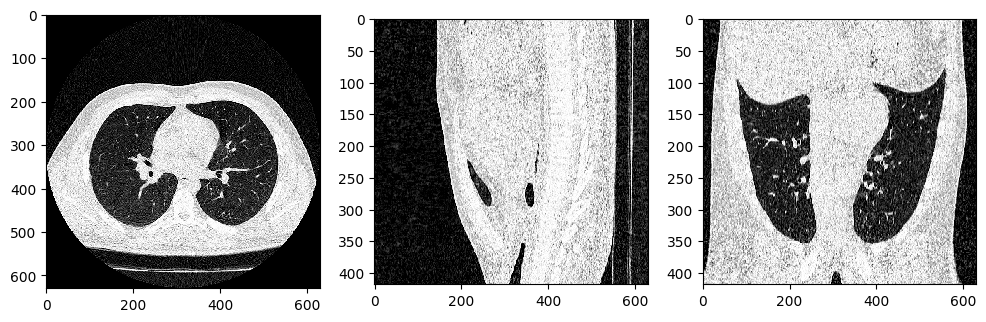

In [13]:
img = (img.astype(np.float32) + 1024) / 1000 * 0.019
img[img < 0] = 0

img = np.rollaxis(img,-1,0)
img = img[np.newaxis, ...]
spacing = np.array(spacing[::-1])

print(spacing)
print(img.shape)

plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(img[0,img.shape[1]//2, ...].T, 'gray', aspect=spacing[1] / spacing[2])
plt.subplot(132); plt.imshow(img[0,:,img.shape[2]//2, :], 'gray', aspect=spacing[0] / spacing[2])
plt.subplot(133); plt.imshow(img[0,...,img.shape[3]//2], 'gray', aspect=spacing[0] / spacing[1])

Test the transformation code

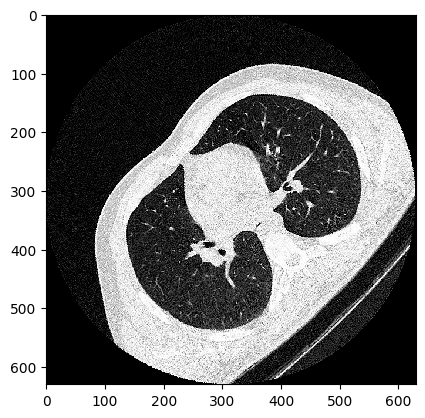

In [18]:
# define translation
t = [0,0,0]
# define rotation
r = [45,0,0]
r = [rr/180 * np.pi for rr in r]
# define scaling
s = [1,1,1]

iimg = img[0,...]

translation,rotation,scale,transformation_matrix = transform.generate_transform_matrix(t,r,s,iimg.shape)

transformation_matrix = transform.transform_full_matrix_offset_center(transformation_matrix, iimg.shape)

img_t = transform.apply_affine_transform(iimg, transformation_matrix)

plt.imshow(img_t[img_t.shape[0]//2,...].T, 'gray', aspect=spacing[1] / spacing[2])

Incorporate the transformation into the projection & backprojection

In [57]:
projector = ct_projector.ct_projector()
projector.from_file('./projector_fan.cfg')
projector.nx = img.shape[3]
projector.ny = img.shape[2]
projector.nz = 1
projector.nv = 1
projector.dx = spacing[2]
projector.dy = spacing[1]
projector.dz = spacing[0]
projector.nview = 500

In [58]:
# very important: make sure that the arrays are saved in C order
cp.cuda.Device(0).use()
ct_projector.set_device(0)

angles = projector.get_angles()
print(angles.shape)

(500,)


In [67]:
## let's define a random motion
## let's say starting from the 200th view to 400th view, we have motion 
start_point = 200
end_point = 400
increment = 100

# define translation
translation = [0,0,0]
# define rotation
rotation = [0,0,0]
rotation = [rr/180 * np.pi for rr in rotation]
# define scaling
scaling = [1,1,1]

slice = [0,64]

# projection data
projection = np.zeros([slice[1] - slice[0],angles.shape[0],1,projector.nu])
print(projection.shape)

for t in np.arange(0,angles.shape[0],increment):
    if t < start_point:
        img_new = np.copy(img)
    if t >= start_point and t<end_point:
        translation_ = [i / (end_point - start_point) * (t - start_point) for i in translation]
        rotation_ = [i / (end_point - start_point) * (t - start_point) for i in rotation]
        # scaling_ = [i / (end_point - start_point) * (t - start_point) for i in scaling]
       

        I = img[0,...]

        _,_,_,transformation_matrix = transform.generate_transform_matrix(translation_,rotation_,scaling,I.shape)
        transformation_matrix = transform.transform_full_matrix_offset_center(transformation_matrix, I.shape)
        img_new = transform.apply_affine_transform(I, transformation_matrix)
        img_new = img_new[np.newaxis, ...]
        
    else:
        I = img[0,...]
        _,_,_,transformation_matrix = transform.generate_transform_matrix(translation,rotation,scaling,I.shape)
        transformation_matrix = transform.transform_full_matrix_offset_center(transformation_matrix, I.shape)
        img_new = transform.apply_affine_transform(I, transformation_matrix)
        img_new = img_new[np.newaxis, ...]
    
    print(img_new.shape)

    origin_img = img_new[0,slice[0]:slice[1],...]
    origin_img = origin_img[:, np.newaxis, ...]

    cuimg = cp.array(origin_img, cp.float32, order = 'C')
    cuangles = cp.array(angles[t:t+increment], cp.float32, order = 'C')

    projector.set_projector(ct_fan.distance_driven_fp, angles=cuangles, branchless=True)
    cufp = projector.fp(cuimg, angles = cuangles)

    fp = cufp.get()
    # print(fp.shape)

    projection[:,t:t+increment,...] = fp
    print(t)


(64, 500, 1, 736)
(1, 418, 630, 630)
0
(1, 418, 630, 630)
100
[0.0, 0.0, 0.0] [0.0, 0.0, 0.0] [0.5, 0.5, 0.5]
(1, 418, 630, 630)
200
[0.0, 0.0, 0.0] [0.0, 0.0, 0.0] [0.5, 0.5, 0.5]
(1, 418, 630, 630)
300
(1, 418, 630, 630)
400


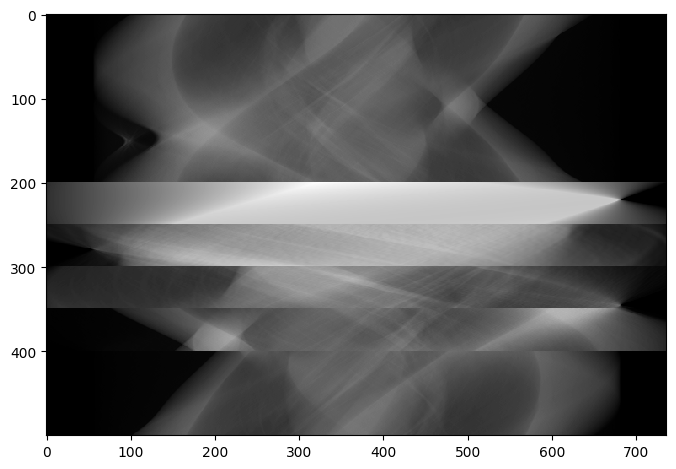

In [64]:
plt.figure(figsize = (8,8))
plt.imshow(projection[1,:, 0, :], 'gray')

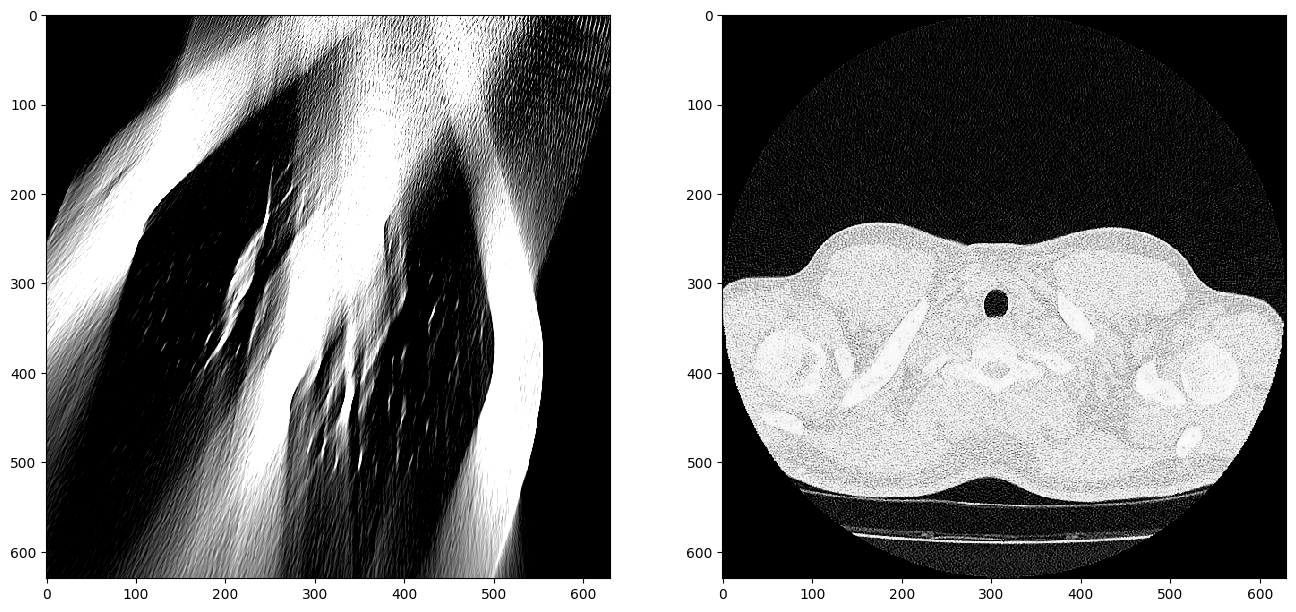

In [65]:
origin_img = img[0, :64, ...]
origin_img = origin_img[:, np.newaxis, ...]
cuimg = cp.array(origin_img, cp.float32, order = 'C')
cuangles = cp.array(angles, cp.float32, order = 'C')



# set fbp
fbp_projector = numpy_projector.ct_projector()
fbp_projector.from_file('./projector_fan.cfg')
fbp_projector.nx = img.shape[3]
fbp_projector.ny = img.shape[2]
fbp_projector.nz = 1
fbp_projector.nv = 1
fbp_projector.dx = spacing[2]
fbp_projector.dy = spacing[1]
fbp_projector.dz = spacing[0]

fprj = numpy_fan.ramp_filter(fbp_projector, fp, filter_type='RL')

projector.set_backprojector(ct_fan.distance_driven_bp, angles=cuangles, is_fbp=True)
cufprj = cp.array(fprj, cp.float32, order = 'C')
curecon = projector.bp(cufprj)

plt.figure(figsize = (16,8))
plt.subplot(121); plt.imshow(curecon.get()[2,0, :, :], 'gray', vmin=0, vmax=0.0225)
plt.subplot(122); plt.imshow(cuimg.get()[2,0, :, :], 'gray', vmin=0, vmax=0.0225)

In [44]:
np.max(cuimg)

array(1160.5283, dtype=float32)